In [1]:
### Importing packages and functions
import sys
import os
#### This should be set as the path of auto in your own computer, if you didn't add the path to your bashrc file
os.environ['AUTO_DIR'] = '/home/contreras/Documents/Auto4Servers/compute2/auto-07p'
import numpy as np
import pylab, json, sympy, scipy
import matplotlib
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc
from copy import copy
### Importing created functions to load model
### Add path to functions
sys.path.insert(1, './functions')
from m_generic_neuron_from_json import generic_neuron_from_json
from m_generic_neuron_from_json import load_mod
### Something for sympy to work with python 3
from sympy import S
from operator import itemgetter
### to create temp files in every run
import contextlib
import tempfile
import shutil
### Import auto stuff
import autoutils
import auto

In [2]:
## Hack for auto to work
%load_ext autoreload
%autoreload 2

In [3]:
# This is to run auto related stuff in a temporary folder (files are created in every run, and are not needed later)
@contextlib.contextmanager
def TemporaryDirectory(suffix="", prefix="tmp", dir=None):
    name = tempfile.mkdtemp(suffix, prefix, dir)
    try:
        yield name
    finally:
        shutil.rmtree(name)

In [4]:
# This is to save the data used to draw the bifurcation diagram
import pickle
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

dir_sims='./Data/'

In [5]:
def saving_pdf_figure(fig,fig_name,md_dir,raster=False):
    from matplotlib.backends.backend_pdf import PdfPages
    ax=plt.figure()
    ax=fig
    ax2=fig
    pdffig = PdfPages(fig_name+".pdf")
    if raster:
        if raster>1:
            rast=raster
        else:
            rast=300
        ax.savefig(fig_name+'.png',dpi=rast)
        fig.savefig(pdffig, format="pdf",dpi=rast)
    else:
        ax.savefig(fig_name+'.png')
        fig.savefig(pdffig, format="pdf")

    metadata = pdffig.infodict()
    metadata['Title'] = md_dir['Title']
    metadata['Author'] = md_dir['Author']
    metadata['Subject'] = md_dir['Subject']
    metadata['Keywords'] = md_dir['Keywords']
    pdffig.close()

In [6]:
def zoomingBox(ax1, roi, ax2, color='red', linewidth=2, roiKwargs={}, arrowKwargs={}):
    from matplotlib.patches import Rectangle
    '''
    **Notes (for reasons unknown to me)**
    1. Sometimes the zorder of the axes need to be adjusted manually...
    2. The figure fraction is accurate only with qt backend but not inline...
    '''
    roiKwargs = dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)] + list(roiKwargs.items()))
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2], **roiKwargs))
    arrowKwargs = dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)] + list(arrowKwargs.items()))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
        src = [0, 3]; dst = [0, 3]
    elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
        src = [1, 2]; dst = [1, 2]
    elif dstBB.max[1] < srcBB.min[1]:
        src = [0, 2]; dst = [1, 3]
    elif dstBB.min[1] > srcBB.max[1]:
        src = [1, 3]; dst = [0, 2]
    elif dstBB.max[0] < srcBB.min[0]:
        src = [0, 1]; dst = [2, 3]
    elif dstBB.min[0] > srcBB.max[0]:
        src = [2, 3]; dst = [0, 1]
    for k in range(2):
        ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', arrowprops=arrowKwargs)

In [7]:
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_expressions_and_ss(neuron_snap,bifpar,autobifpart):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    ##############################333##############################333##############################333
    ############## # Running model with ode, to find the steady state to auto as initial conditions   ###########333#
    ##############################333##############################333##############################333
    neuron_fromgen_4sim.changing_pars(bifpar,strIapp=strIapp)
    # Constant input stimuli
    I_exp1 = lambda t: 0 if t<0 else autobifpart[strIapp]
    t=np.linspace(0, 1000.0, 1000.0/0.01)
    # Running ODE
    s_results, v_results=neuron_fromgen_4sim.stimulate_neuron(t,neuron_fromgen_4sim.current_state,I_exp1)
    inivals = ([float(v_results[:,s_results.index(j)][-1]) for j in var])
    return var,rhs,spikecriterion,J,inivals

#########################################################
#### Function to adjust Jmat dimensions for eigenvalue calculation..
#########################################################
def fixing_jmat(Jmat):
    m_JMat = [[0 for x in range(len(Jmat))] for y in range(len(Jmat))]
    for i in range(len(Jmat)):
        for j in range(len(Jmat)):
            if 'array' in str(type(Jmat[i][j])):
                m_JMat[i][j]=Jmat[i][j]
            else:
                m_JMat[i][j]=np.array([Jmat[i][j]])

    m_JMat = [np.concatenate(j) for j in m_JMat]
    return m_JMat



In [8]:
### Importing the thesis format for figures
import json
P= json.load(open("cfg/Thesis_mpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])

fig_wide=matplotlib.rcParams["figure.figsize"][0]
fig_height=matplotlib.rcParams["figure.figsize"][1]

In [9]:
## Loading neuron model (file in the cfg folder)
model_name_p0='MTM_W_sPNaS_snapshot_p0'
### How is the applied current parameter called
strIapp='I_app'
### creating a class neuron from m_generic_neuron_from_json that clasifies the expressions for ode
neuron_snap=generic_neuron_from_json(model_name_p0+'.json',strIapp=strIapp)
x_neuron=copy(neuron_snap)
### We will choose for the analysis this model..
model_name=model_name_p0

### Importing data created in Bifurcation_Graph_Ko.ipynb

In [10]:
### Importing data that created the bif graph
dir_sims='./Data/'
name='Bifurcation_Graph_Iapp_Ko_'+model_name
f=open(dir_sims+name+'.pkl', 'rb')
d_Bif_graph_data=pickle.load(f)

v_s_par=d_Bif_graph_data['Bif_parameters']
v_s_var=d_Bif_graph_data['state_pars']
m_res_par_sn_KoIapp=d_Bif_graph_data['saddle_node_par']
m_res_statev_sn_KoIapp=d_Bif_graph_data['saddle_node_var']
m_res_par_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_par']
m_res_statev_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_var']
m_res_par_HF0=d_Bif_graph_data['Hopf_par']
m_res_statev_HF=d_Bif_graph_data['Hopf_var']


/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


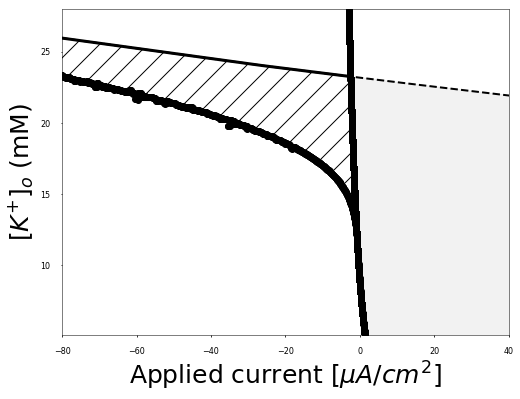

In [11]:
from scipy.interpolate import interp1d
size_axis_font=25
plt.close("all")

fig01 = plt.figure(facecolor="1",figsize=(8,6))
axx = fig01.add_subplot(111)
xlim=[-80,40]
ylim=[5.1,28]
axx.set_xlim(xlim)
axx.set_ylim(ylim)

s_x=1;s_y=0
##### plot sn disappearance, hopf and limit cycle onset
axx.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],'o',color=[0,0,0])
axx.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],'o',color=[0,0,0])
axx.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',linewidth=2,color=[0,0,0])

##### Drawing the different regions
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
bx=m_res_par_sn_KoIapp[s_x]
c=m_res_par_HF0[s_x]
cy=m_res_par_HF0[s_y]
f1x = interp1d(m_res_par_sn_KoIapp[s_y][bx.argsort()],bx[bx.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
f2x = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
f3x = interp1d(m_res_par_HF0[s_y][c.argsort()],c[c.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
yy=m_res_par_sn_KoIapp[s_x][b.argsort()]
yy2=np.minimum(f3x(b[b.argsort()]),yy)

##### filling the different regions
axx.fill_betweenx(b[b.argsort()],f2x(b[b.argsort()]),yy2,facecolor="none",hatch="/",lw=3., edgecolor='k')
cc=[i for i in b.argsort() if f3x(b[i])>f1x(b[i])]
axx.fill_betweenx(b[cc],f1x(b[cc]),f3x(b[cc]),color='k',alpha=.05)

##### Plot axes
axx.set_ylabel('$[K^{+}]_o $ (mM)',fontsize=size_axis_font)
axx.set_xlabel('Applied current $[\mu A/cm^2]$',fontsize=size_axis_font)
axx.tick_params(axis='y', pad=10)
axx.tick_params(axis='x', pad=10)
plt.show()




# $<P_{ISI}>$ FI

In [13]:
#### Check potentials
from sympy import S, symbols, lambdify
from sympy.parsing.sympy_parser import parse_expr
from scipy.special import erf


v_u_ISI_Traub=[]
v_sigma_ISI_Traub=[]

v_schleim_approx=[]
v_schleim_numeric=[]

v_schleim_sigma_approx=[]
v_schleim_sigma_numeric=[]

v_Ko=[]
v_I_app=[]

v_tau_e_Traub=[]
v_ynys0=[]
v_dltUovD=[]
v_len_isifp_Traub=[]

v_siigma=[]
### Noise intensity
sii=0.5#\muA

v_len_4_line_int=[]
v_len_isifp_Traub=[]

for K_o in [12.5,12.75,13.0,13.25,13.5]:
    I_app=-10
    ### Finding bistable region boundaries for particular Ko
    lb=m_res_par_lc_KoIapp[s_x][np.argmin(np.abs(m_res_par_lc_KoIapp[s_y]-K_o))]
    ub=m_res_par_sn_KoIapp[s_x][np.argmin(np.abs(m_res_par_sn_KoIapp[s_y]-K_o))]

    ## Applied currents in the subthreshold, bistable, and spiking regions.
    if (ub-lb)/5>1*10**-3:
#         t_I_app_specf=[lb+(ub-lb)/5,lb+2*(ub-lb)/5,lb+3*(ub-lb)/5,lb+4*(ub-lb)/5]
        t_I_app_specf=[lb+(ub-lb)/10,lb+2*(ub-lb)/10,lb+3*(ub-lb)/10,lb+4*(ub-lb)/10,lb+5*(ub-lb)/10,lb+6*(ub-lb)/10,lb+7*(ub-lb)/10,lb+8*(ub-lb)/10,lb+9*(ub-lb)/10]
    else:
        t_I_app_specf=[lb+(ub-lb)/2]
        
        
    ### Noise only in the voltage dimension
    sigma_v=[sii,0,0,0]
    ## To load simulation
    num_neurons=500
    for ii_iapi in range(len(t_I_app_specf)):
        I_app=t_I_app_specf[ii_iapi]
        bifpar={}
        bifpar[strIapp] = [str(t_I_app_specf[ii_iapi])+"* uA/cm2"]
        bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
        name='SIM_'+model_name+'_I_app_'+bifpar['I_app'][0][0:bifpar['I_app'][0].index('*')]+'_K_o_'+bifpar['K_o'][0][1:bifpar['K_o'][0].index('*')]+'_sigma_'+str(sigma_v[0])
        
        if os.path.isfile('./Data/'+name+'.pkl'):
            print(name+' exists!')
            f=open('./Data/'+name+'.pkl', 'rb')
            d_save_sim=pickle.load(f)
            f.close()
            ####################### Extract attractor properties
            l0=d_save_sim['Dyn_Sys_Properties']['l0']
            limit_cycle=d_save_sim['Dyn_Sys_Properties']['limit_cycle']
            tau_lc=d_save_sim['Dyn_Sys_Properties']['tau_lc']
            saddle=d_save_sim['Dyn_Sys_Properties']['saddle']
            node=d_save_sim['Dyn_Sys_Properties']['stable']
            lam0=d_save_sim['Dyn_Sys_Properties']['lam0']
            lamfp=d_save_sim['Dyn_Sys_Properties']['lamfp']
            
            if len(d_save_sim['Dyn_Sys_Properties']['limit_cycle'])>0 and 'PRC' in d_save_sim['Dyn_Sys_Properties'].keys():
                PRC=d_save_sim['Dyn_Sys_Properties']['PRC']
                ### Distances in l0
                dlc=min(np.dot(l0,limit_cycle-saddle))
                yn=np.dot(l0,node)
                ys_0=np.dot(l0,saddle)
                sig_eff=np.dot(sigma_v,l0)
                D=sig_eff**2
                
                #### Loading ISIs of trajectories that go through the fp.
                v_ISI=[]
                if len(d_save_sim['Mult_spike_reals']['ISI_fp'])>0:
                    ISI_fp_Traub=np.concatenate(d_save_sim['Mult_spike_reals']['ISI_fp'])
                    v_ISI=[]
                    for ii,ii_spikes in enumerate(np.concatenate(d_save_sim['Mult_spike_reals']['spikes'])):
                        v_isi=ii_spikes[1:]-ii_spikes[:-1]
                        v_ISI.append(v_isi)

                    v_ISI=np.concatenate(v_ISI)


                if len(v_ISI)>2:
                    v_len_isifp_Traub.append(len(ISI_fp_Traub))
                    ## Storing d_fp
                    v_ynys0.append(yn-ys_0)
                    v_siigma.append(sii)
                    v_Ko.append(K_o)
                    v_I_app.append(I_app)
                    ##############################################################################################################
                    ########## T_esc_theor from line integral
                    ##############################################################################################################
                    ### Loading the line integral in l0 that was calculated in (p_traub_to_GIF_potentials.py)
                    dir_sims='./Data/'
                    name='d_sample_of_det_potentials_'+model_name
                    f=open(dir_sims+name+'.pkl', 'rb')
                    d_POTs=pickle.load(f)
                    f.close()
                    ############################################################
                    ### Finding the potential for this particular Iapp and Uy
                    ############################################################
                    v_Iappi_pots=[]
                    v_Ko_pots=[]
                    for d_pot_i in d_POTs:
                        v_Ko_pots.append(d_pot_i['K_o'])
                        v_Iappi_pots.append(d_pot_i['I_app'])

                    pot_idx=np.array(range(len(v_Iappi_pots)))[v_Iappi_pots==I_app]
                    if len(pot_idx)==1 and v_Ko_pots[pot_idx[0]]==K_o:
                        pot_idx=pot_idx[0]
                    elif len(pot_idx)>1:
                        for ii_poti_idx in pot_idx:
                            if v_Ko_pots[pii_poti_idx]==K_o:
                                pot_idx=ii_poti_idx

                    yy_tot_t=d_POTs[pot_idx]['Dyn_Sys_Properties']['Det_Uy_in_l0']['yy_tot_t']
                    Uy_tot_t=d_POTs[pot_idx]['Dyn_Sys_Properties']['Det_Uy_in_l0']['Uy_tot_t']
                    ### shifting Uy such that U(0)=0
                    Uy_tot_t=Uy_tot_t-Uy_tot_t[np.argmin(abs(yy_tot_t))]
                    ############################################################
                    ### Decreasing resolution, to optimize running time
                    ############################################################
                    delta=0.001
                    idxs_Vy_shrt=[]
                    idxs_Vy_shrt.append(np.array(range(len(yy_tot_t)))[1:][np.diff(yy_tot_t)>delta])
                    idxs_Vy_shrt.append(np.array(range(len(yy_tot_t)))[1:][(np.diff(yy_tot_t)<delta)*(np.diff(yy_tot_t)>0)][::5])
                    idxs_Vy_shrt=np.sort(np.concatenate(idxs_Vy_shrt))
                    Uy_temp=Uy_tot_t[idxs_Vy_shrt]
                    yy_temp=yy_tot_t[idxs_Vy_shrt]
                    v_len_4_line_int.append(len(np.array(range(len(yy_temp)))[(yy_temp>=yn[0]-ys_0[0])*(yy_temp<=float('%.4g' % dlc))]))
                    print(len(np.array(range(len(yy_temp)))[(yy_temp>=yn[0]-ys_0[0])*(yy_temp<=float('%.4g' % dlc))]))
                    #######################  Escape rate, no simplifications #
                    ##### 5.2.165 Gardiner.. (without simplifications..)
                    def int1(y_a,y_b):
                        idxs_Vy=np.array(range(len(yy_temp)))[(yy_temp>=y_a)*(yy_temp<=y_b)]
                        v_y=yy_temp[idxs_Vy]
                        return np.trapz((np.exp(Uy_temp[idxs_Vy]/D))*int2(v_y),x=v_y)

                    def int2(v_yi):
                        v_int1=[]
                        count=0
                        for yi in v_yi:
                            if int((count/len(v_yi))*100)==(count/len(v_yi))*100:
                                print(str(int((count/len(v_yi))*100))+'%')

                            idxs_Vy=np.array(range(len(yy_temp)))[(yy_temp>=-100.0)*(yy_temp<=yi)]
                            v_y=yy_temp[idxs_Vy]
                            v_int1.append(np.trapz(np.exp(-Uy_temp[idxs_Vy]/D),x=v_y))
                            count+=1

                        return v_int1

                    T_esc_theor=(1.0/D)*int1(yn[0]-ys_0[0],float('%.4g' % dlc))
                    T_kramers=2*np.pi*(1/np.sqrt(abs(lam0)*abs(lamfp)))*np.exp((Uy_tot_t[np.argmin(abs(yy_tot_t))]-Uy_tot_t[np.argmin(abs(yy_tot_t-(yn[0]-ys_0[0])))])/D)
                    ####################### 
                    ###### Mixing factor
                    #9.1.10 Gardiner.. (numerica solution).. assuming, initial condition sqrt(D) away from dl
                    def phi_a(y_a,y_b,y_c):
                        ### First limits of integration
                        idxs_Vy=np.array(range(len(yy_temp)))[(yy_temp>=y_b)*(yy_temp<=y_c)]
                        v_y=yy_temp[idxs_Vy]
                        inti_nom=np.trapz(np.exp(Uy_temp[idxs_Vy]/D),x=v_y)
                        ### Second limits of integration
                        idxs_Vy=np.array(range(len(yy_temp)))[(yy_temp>=y_a)*(yy_temp<=y_c)]
                        v_y=yy_temp[idxs_Vy]
                        inti_denom=np.trapz(np.exp(Uy_temp[idxs_Vy]/D),x=v_y)
                        return inti_nom/inti_denom


                    ### instead of upper integration boundary of equation 39 to be inf, is set to 5.0>>d_lc
                    omega_numeric=phi_a(yn[0]-ys_0[0],float('%.4g' % dlc),5.0)
                    ####################### 
                    ###### Mixing factor
                    #9.1.21 Gardiner.. (Solution for infinitesimally distant from b)
                    omega_aprox=(1/2)*(1-erf(dlc*np.sqrt(abs(lam0)/(D))))
                    
                    sch_approx=np.array(omega_aprox)*np.array(T_kramers)+np.array(tau_lc)
                    sch_lineint=np.array(omega_numeric)*np.array(T_esc_theor)+np.array(tau_lc)
                    
                    
                    x=np.linspace(0,1,len(PRC["v"]))
                    y=PRC["v"]*PRC["v"]
                    beta_c=sum(y)*(1.0-0)/len(x)
                    D_lc=beta_c*sii**2
                    
                    sch_approx_sigma=(tau_lc**2)*(1+D_lc*tau_lc)+2*omega_aprox*T_kramers*(tau_lc+T_kramers)
                    sch_lineint_sigma=(tau_lc**2)*(1+D_lc*tau_lc)+2*omega_numeric*T_esc_theor*(tau_lc+T_esc_theor)
                    
                    v_u_ISI_Traub.append(np.mean(v_ISI))
                    v_sigma_ISI_Traub.append(np.var(v_ISI))
                    v_schleim_approx.append(sch_approx)
                    v_schleim_numeric.append(sch_lineint)
                    v_schleim_sigma_approx.append(sch_approx_sigma)
                    v_schleim_sigma_numeric.append(sch_lineint_sigma)
                    
                else:
                    print('not enough ISIs..')
                
            else:
                print('no limit cycle :(...')



            


SIM_MTM_W_sPNaS_snapshot_p0_I_app_-0.960852858332_K_o_12.5_sigma_0.5 exists!
8232
0%
25%
50%
75%
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-0.949213190774_K_o_12.5_sigma_0.5 exists!
9204
0%
25%
50%
75%
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-0.937573523216_K_o_12.5_sigma_0.5 exists!
10821
0%
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-0.925933855658_K_o_12.5_sigma_0.5 exists!
11933
0%
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.076300466075_K_o_12.75_sigma_0.5 exists!
no limit cycle :(...
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.06392985175_K_o_12.75_sigma_0.5 exists!
7282
0%
50%
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.051559237425_K_o_12.75_sigma_0.5 exists!
7260
0%
5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
60%
65%
70%
75%
80%
85%
90%
95%
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.0391886231_K_o_12.75_sigma_0.5 exists!
7530
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.0268180087749998_K_o_12.75_sigma_0.5 exists!
7595
0%
20%
40%
60%
80%
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.0144473944499999_K_o_12.75

In [14]:
#### Minimum number of observations to consider
ii_num_thres=44000

### more than ii_num_thres visits to fp and to lc in both models..
a_tb=(np.array(v_len_isifp_Traub)>ii_num_thres)
b_inti_b=(np.array(v_len_4_line_int)>4000)

# acpt_thres=np.array(range(len(v_u_ISI_Traub)))[a_tb*b_tb*a_pif*b_pif*a_pif_v*b_pif_v]
acpt_thres=np.array(range(len(v_len_isifp_Traub)))[a_tb*b_inti_b]


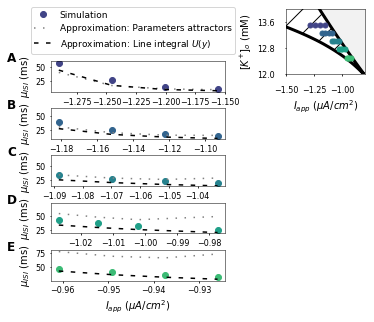

<Figure size 410.4x360 with 0 Axes>

In [85]:

from sympy import S, symbols, lambdify
from sympy.parsing.sympy_parser import parse_expr
from scipy.special import erf

### Properties of 
###############################################################################################################
##### Figure.. ISI dist and escape rate..
###############################################################################################################

### Noise only in the voltage dimension
sii=0.5#\muA
sigma_v=[sii,0,0,0] 
num_neurons=500

##############################################################################################################
##### Figure.. Axes..

plt.close("all")
f1 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height))
# axpl = plt.subplot2grid((len(np.unique(v_Ko))*18-6+20,80), ((len(np.unique(v_Ko))-1)*18-30, 59), colspan=20,rowspan=18)
axpl = plt.subplot2grid((len(np.unique(v_Ko))*18-6+20,80), (0, 59), colspan=20,rowspan=25)

##############################################################################################################
##### principal axes with the bif graph.. Axes..

axpl.set_xlim([-1.5,-0.8])
axpl.set_ylim([12,14])
### Classic bif graphs... instead of scattered version
s_x=1;s_y=0
##### plot sn disappearance, hopf and limit cycle onset
axpl.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],color=[0,0,0])
axpl.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],color=[0,0,0])
axpl.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',color=[0,0,0])

##### Drawing the different regions
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
bx=m_res_par_sn_KoIapp[s_x]
c=m_res_par_HF0[s_x]
cy=m_res_par_HF0[s_y]
f1x = interp1d(m_res_par_sn_KoIapp[s_y][bx.argsort()],bx[bx.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
f2x = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
f3x = interp1d(m_res_par_HF0[s_y][c.argsort()],c[c.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
yy=m_res_par_sn_KoIapp[s_x][b.argsort()]
yy2=np.minimum(f3x(b[b.argsort()]),yy)

##### filling the different regions
axpl.fill_betweenx(b[b.argsort()],f2x(b[b.argsort()]),yy2,facecolor="none",hatch="/",lw=3., edgecolor='k')
cc=[i for i in b.argsort() if f3x(b[i])>f1x(b[i])]
axpl.fill_betweenx(b[cc],f1x(b[cc]),f3x(b[cc]),color='k',alpha=.05)

##### Plot axes
axpl.set_ylabel('$[K^{+}]_o$ (mM)')
axpl.set_xlabel('$I_{app}$ $(\mu A/cm^2)$')
axpl.tick_params(axis='y', pad=10)
axpl.tick_params(axis='x', pad=10)

jet= plt.get_cmap('viridis')
colors = iter(jet(np.linspace(0.2,0.8,len(np.unique(v_Ko))+1)))
colorii=next(colors)
##############################################################################################################
##### Extract data from simulation..
### To equalize scale of y axis
brd_fr=0
ax_v=[]

v_len=[]
for ii_koi,koi in enumerate(np.unique(v_Ko)[::-1]):
    x=np.array(v_I_app)[acpt_thres]
    y=np.array(v_u_ISI_Traub)[acpt_thres]
    z=np.array(v_Ko)[acpt_thres]
    v_len.append(len(x[koi==z]))
    
    
for ii_koi,koi in enumerate(np.unique(v_Ko)[::-1]):

    if len(np.array(v_Ko)[acpt_thres][koi==np.array(v_Ko)[acpt_thres]])>1:
        ax_v.append(plt.subplot2grid((len(np.unique(v_Ko))*18-6+20,80), (ii_koi*18+20, 0),colspan=44,rowspan=12))

        x=np.array(v_I_app)[acpt_thres]
        y=np.array(v_u_ISI_Traub)[acpt_thres]
        z=np.array(v_Ko)[acpt_thres]
        ax_v[-1].plot(x[koi==z][-min(v_len):],y[koi==z][-min(v_len):],'o',color=colorii,label='Simulation')

            
        sch=np.array(v_schleim_approx)[acpt_thres]
        ax_v[-1].plot(x[koi==z][-min(v_len):],sch[koi==z][-min(v_len):], dashes=(1, 5),color='gray',label='Approximation: Parameters attractors')

            
        sch=np.array(v_schleim_numeric)[acpt_thres]
        ax_v[-1].plot(x[koi==z][-min(v_len):],sch[koi==z][-min(v_len):],dashes=(3, 5),color='black',label='Approximation: Line integral $U(y)$')

            
        ax_v[-1].set_ylabel(r'$\mu_{ISI}$ (ms)')
        
        axpl.plot(x[koi==z][-min(v_len):],koi*np.ones(len(x[koi==z]))[-min(v_len):],'o',markersize=5,color=colorii)
        colorii=next(colors)
        
            
            
    else:
        print('File '+name+'...Doesnt exist :(:(')
        



ax_v[-1].set_xlabel('$I_{app}$ $(\mu A/cm^2)$')
# ax_v[-1].legend(bbox_to_anchor=(1.1, 1))
ax_v[0].legend(loc='upper center', bbox_to_anchor=(0.47, 2.9),
          ncol=1, fancybox=True, )

############################################
### Labels
############################################
# v_ax=np.concatenate([ax_v,[axpl]])
v_ax=ax_v
import string
ni=0
for n, axs in enumerate(v_ax):
    if n==len(v_ax):
        print('trying to fix')
        axs.text(-0.6, 0.98, string.ascii_uppercase[n], transform=axs.transAxes, 
            size=matplotlib.rcParams["font.size"], weight='bold')
    else:
        axs.text(-0.25, 0.98, string.ascii_uppercase[n], transform=axs.transAxes, 
                size=matplotlib.rcParams["font.size"],weight='bold')



brd_fr=1
for ii in range(len(ax_v)):
    brd_fr_ii=ax_v[ii].get_ylim()[-1]-ax_v[ii].get_ylim()[0]
    if brd_fr<brd_fr_ii:
        brd_fr=brd_fr_ii
    
for ii in range(len(ax_v)):
    ax_v[ii].set_ylim([ax_v[ii].get_ylim()[0],ax_v[ii].get_ylim()[0]+brd_fr])
    
axpl.yaxis.set_major_locator(plt.MaxNLocator(3))
    
fig_name='traces_4_different_ISIs_wPisi_quality_uISI_t_'+model_name

md_dir={}
md_dir['Title']='mean ISI for traces with different dlc and dsn in bistable region with distribution of PISI(t)'+model_name+' for sigmav='+str(sigma_v)+' Ko=='+''.join(['_'+str(i_ko_ii) for i_ko_ii in np.unique(v_Ko)])
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

saving_pdf_figure(f1,'./figs/'+fig_name,md_dir,raster=300)

# plt.show()

In [30]:
md_dir

{'Title': 'mean ISI for traces with different dlc and dsn in bistable region with distribution of PISI(t)MTM_W_sPNaS_snapshot_p0 for sigmav=[0.5, 0, 0, 0] Ko==_12.5_12.75_13.0_13.25_13.5',
 'Author': 'Susana Contreras',
 'Subject': 'stochastic bursting',
 'Keywords': 'Bistability, concentration dynamics, spiking statistics'}

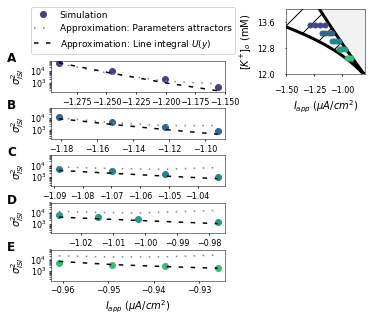

<Figure size 410.4x360 with 0 Axes>

In [84]:

from sympy import S, symbols, lambdify
from sympy.parsing.sympy_parser import parse_expr
from scipy.special import erf

### Properties of 
###############################################################################################################
##### Figure.. ISI dist and escape rate..
###############################################################################################################

### Noise only in the voltage dimension
sii=0.5#\muA
sigma_v=[sii,0,0,0] 
num_neurons=500

##############################################################################################################
##### Figure.. Axes..

plt.close("all")
f1 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height))
# axpl = plt.subplot2grid((len(np.unique(v_Ko))*18-6,80), ((len(np.unique(v_Ko))-1)*18-30, 59), colspan=20,rowspan=18)
axpl = plt.subplot2grid((len(np.unique(v_Ko))*18-6+20,80), (0, 59), colspan=20,rowspan=25)

##############################################################################################################
##### principal axes with the bif graph.. Axes..

axpl.set_xlim([-1.5,-0.8])
axpl.set_ylim([12,14])
### Classic bif graphs... instead of scattered version
s_x=1;s_y=0
##### plot sn disappearance, hopf and limit cycle onset
axpl.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],color=[0,0,0])
axpl.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],color=[0,0,0])
axpl.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',color=[0,0,0])

##### Drawing the different regions
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
bx=m_res_par_sn_KoIapp[s_x]
c=m_res_par_HF0[s_x]
cy=m_res_par_HF0[s_y]
f1x = interp1d(m_res_par_sn_KoIapp[s_y][bx.argsort()],bx[bx.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
f2x = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
f3x = interp1d(m_res_par_HF0[s_y][c.argsort()],c[c.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
yy=m_res_par_sn_KoIapp[s_x][b.argsort()]
yy2=np.minimum(f3x(b[b.argsort()]),yy)

##### filling the different regions
axpl.fill_betweenx(b[b.argsort()],f2x(b[b.argsort()]),yy2,facecolor="none",hatch="/",lw=3., edgecolor='k')
cc=[i for i in b.argsort() if f3x(b[i])>f1x(b[i])]
axpl.fill_betweenx(b[cc],f1x(b[cc]),f3x(b[cc]),color='k',alpha=.05)

##### Plot axes
axpl.set_ylabel('$[K^{+}]_o$ (mM)')
axpl.set_xlabel('$I_{app}$ $(\mu A/cm^2)$')
axpl.tick_params(axis='y', pad=10)
axpl.tick_params(axis='x', pad=10)

jet= plt.get_cmap('viridis')
colors = iter(jet(np.linspace(0.2,0.8,len(np.unique(v_Ko))+1)))
colorii=next(colors)
##############################################################################################################
##### Extract data from simulation..
### To equalize scale of y axis
brd_fr=0
ax_v=[]

v_len=[]
for ii_koi,koi in enumerate(np.unique(v_Ko)[::-1]):
    x=np.array(v_I_app)[acpt_thres]
    y=np.array(v_u_ISI_Traub)[acpt_thres]
    z=np.array(v_Ko)[acpt_thres]
    v_len.append(len(x[koi==z]))
    
    
for ii_koi,koi in enumerate(np.unique(v_Ko)[::-1]):

    if len(np.array(v_Ko)[acpt_thres][koi==np.array(v_Ko)[acpt_thres]])>1:
        if len(ax_v)<1:
            ax_v.append(plt.subplot2grid((len(np.unique(v_Ko))*18-6+20,80), (ii_koi*18+20, 0),colspan=44,rowspan=12))

        else:
            ax_v.append(plt.subplot2grid((len(np.unique(v_Ko))*18-6+20,80), (ii_koi*18+20, 0),colspan=44,rowspan=12,sharey=ax_v[0]))

        x=np.array(v_I_app)[acpt_thres]
        y=np.array(v_sigma_ISI_Traub)[acpt_thres]
        z=np.array(v_Ko)[acpt_thres]
        ax_v[-1].plot(x[koi==z][-min(v_len):],y[koi==z][-min(v_len):],'o',color=colorii,label='Simulation')

            
        sch=np.array(v_schleim_sigma_approx)[acpt_thres]
        ax_v[-1].plot(x[koi==z][-min(v_len):],sch[koi==z][-min(v_len):], dashes=(1, 5),color='gray',label='Approximation: Parameters attractors')

            
        sch=np.array(v_schleim_sigma_numeric)[acpt_thres]
        ax_v[-1].semilogy(x[koi==z][-min(v_len):],sch[koi==z][-min(v_len):],dashes=(3, 5),color='black',label='Approximation: Line integral $U(y)$')

            
        ax_v[-1].set_ylabel(r'$\sigma_{ISI}^2$')
        
        axpl.plot(x[koi==z][-min(v_len):],koi*np.ones(len(x[koi==z]))[-min(v_len):],'o',markersize=5,color=colorii)
        colorii=next(colors)
        
            
            
    else:
        print('File '+name+'...Doesnt exist :(:(')
        



ax_v[-1].set_xlabel('$I_{app}$ $(\mu A/cm^2)$')
# ax_v[-1].legend(bbox_to_anchor=(1.1, 1))
ax_v[0].legend(loc='upper center', bbox_to_anchor=(0.47, 2.9),
          ncol=1, fancybox=True, )

############################################
### Labels
############################################
# v_ax=np.concatenate([ax_v,[axpl]])
v_ax=ax_v
import string
ni=0
for n, axs in enumerate(v_ax):
    if n==len(v_ax):
        axs.text(-0.6, 0.98, string.ascii_uppercase[n], transform=axs.transAxes, 
            size=matplotlib.rcParams["font.size"], weight='bold')
    else:
        axs.text(-0.25, 0.98, string.ascii_uppercase[n], transform=axs.transAxes, 
                size=matplotlib.rcParams["font.size"],weight='bold')


# brd_fr=1
# for ii in range(len(ax_v)):
#     brd_fr_ii=ax_v[ii].get_ylim()[-1]-ax_v[ii].get_ylim()[0]
#     if brd_fr<brd_fr_ii:
#         brd_fr=brd_fr_ii
    
# for ii in range(len(ax_v)):
#     ax_v[ii].set_ylim([ax_v[ii].get_ylim()[0]-200,ax_v[ii].get_ylim()[0]+brd_fr])
 
axpl.yaxis.set_major_locator(plt.MaxNLocator(3))
    
fig_name='traces_4_different_ISIs_wPisi_quality_sigmaISI_t_'+model_name

md_dir={}
md_dir['Title']='variance of ISI for different dlc and dsn in bistable region with distribution of PISI(t)'+model_name+' for sigmav='+str(sigma_v)+' Ko=='+''.join(['_'+str(i_ko_ii) for i_ko_ii in np.unique(v_Ko)])
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

saving_pdf_figure(f1,'./figs/'+fig_name,md_dir,raster=300)

# plt.show()